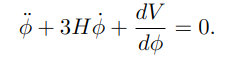

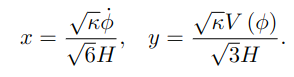

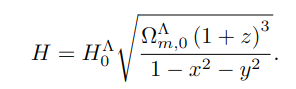

In [66]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative

In [67]:
plt.style.use('cyberpunk')
# mplcyberpunk.make_lines_glow()

In [68]:
nodos=50
ANN = nn.Sequential(nn.Linear(1, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,2))
print(ANN)

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=2, bias=True)
)


In [69]:
#The domain and the batch for the training
ti=-2.4 #z=10
tf=0.0 #z=0

t=torch.linspace(ti,tf,1000).view(-1,1)
t.cuda();

In [70]:
#observational data:
datosH=np.loadtxt('datosH.txt')
datosH = torch.Tensor(datosH)
z=datosH[:,0].view(-1,1)
H=datosH[:,1].view(-1,1)

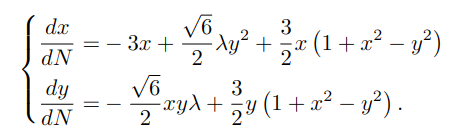

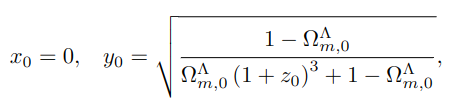

### Real solution

In [71]:
# Definimos el sistema de ecuaciones
ld=1.5
Olm0=0.3
def f(X,N):
    x,y=X
    Dx = -3*x + 1.22*ld*y**2 + 1.5*x*(1+x**2-y**2)
    Dy = -1.22*ld*x*y + 1.5*y*(1+x**2 - y**2)
    # Combine Dx and Dy into a single array
    return np.array([Dx, Dy])


# Definimos las condiciones iniciales
x0 = 0.0
y0 = 0.3

# Definimos el intervalo de integración
N_0 = -2.4
N_f = 0

N=np.linspace(N_0,N_f,50)

# Solucionamos la ecuación diferencial
sol = odeint(f, [x0, y0],N)


In [72]:

def cost(t):
    t0=torch.tensor([[ti]], requires_grad=True)
    #z.requires_grad=True

    x=ANN(t)[:,0].view(-1,1)
    y=ANN(t)[:,1].view(-1,1)
    #rho_l=ANN(t)[:,2].view(-1,1)

    Dx = nth_derivative(ANN,t, 0, 0,1)
    Dy = nth_derivative(ANN,t, 1, 0,1)
    #D_Ol = nth_derivative(ANN,t, 2, 0,1)

    #pi = g_l*Ol + g_r*Or + g_m*Om

    a=torch.mean((Dx + 3*x -1.22*ld*y**2 - 1.5*x*(1+x**2-y**2))**2)
    b=torch.mean((Dy + 1.22*ld*x*y - 1.5*y*(1+x**2 - y**2))**2)
    #c=torch.mean((D_Om - 3*g_m*rho_m/(t+1))**2)

    # rhor=ANN(z)[:,0].view(-1,1)
    # rhom=ANN(z)[:,1].view(-1,1)
    # rhol=ANN(z)[:,2].view(-1,1)
    h0=ANN(t0)-torch.tensor([[0,Olm0]])
    
    return  a + b + torch.mean(h0**2) 

In [73]:
cost(t)

tensor(0.0699, grad_fn=<AddBackward0>)

In [74]:
learning_rate=0.01
epocas=5000


optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)

Training: 100%|███████████████████████████████████| 5000/5000 [00:54<00:00, 92.19it/s, loss=1.22e-6]


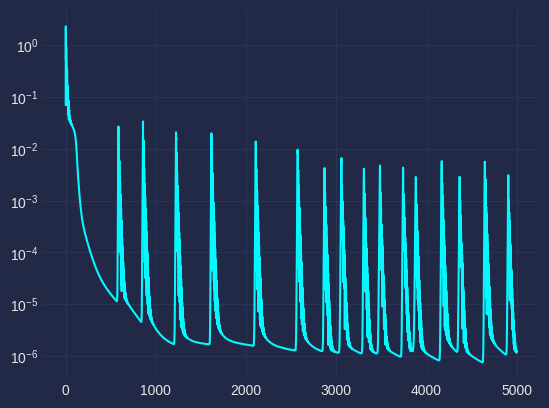

In [75]:
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(t) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)
plt.yscale('log')

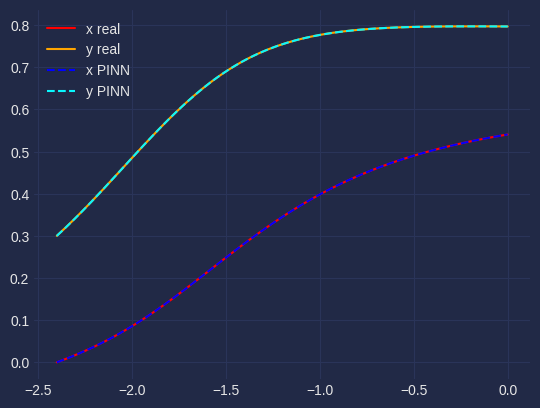

In [82]:
sol_x=ANN(t)[:,0].view(-1,1)
sol_y=ANN(t)[:,1].view(-1,1)
#rhol=ANN(z)[:,2].view(-1,1)
#Hz = 67.0


plt.plot(N,sol[:, 0], label='x real', color='red')
plt.plot(N, sol[:, 1], label='y real', color='orange')
    
plt.plot(t.detach(),sol_x.detach(), '--',label='x PINN', color='blue')
plt.plot(t.detach(),sol_y.detach(), '--', label='y PINN')
plt.legend()

In [83]:
zH=torch.linspace(0.0,3.0,30).view(-1,1)
# sol_x=ANN(-torch.log(zH+1))[:,0].view(-1,1)
# sol_y=ANN(-torch.log(zH+1))[:,1].view(-1,1)
H_quin=67.0*torch.sqrt(Olm0/(1-sol_x**2 - sol_y**2) * torch.exp(3*t))

In [84]:
1-sol_x**2 - sol_y**2

tensor([[0.9100],
        [0.9094],
        [0.9088],
        [0.9082],
        [0.9076],
        [0.9070],
        [0.9064],
        [0.9058],
        [0.9052],
        [0.9046],
        [0.9040],
        [0.9034],
        [0.9027],
        [0.9021],
        [0.9015],
        [0.9008],
        [0.9002],
        [0.8995],
        [0.8989],
        [0.8982],
        [0.8976],
        [0.8969],
        [0.8963],
        [0.8956],
        [0.8949],
        [0.8942],
        [0.8936],
        [0.8929],
        [0.8922],
        [0.8915],
        [0.8908],
        [0.8901],
        [0.8894],
        [0.8887],
        [0.8880],
        [0.8873],
        [0.8865],
        [0.8858],
        [0.8851],
        [0.8844],
        [0.8836],
        [0.8829],
        [0.8821],
        [0.8814],
        [0.8806],
        [0.8799],
        [0.8791],
        [0.8784],
        [0.8776],
        [0.8768],
        [0.8760],
        [0.8753],
        [0.8745],
        [0.8737],
        [0.8729],
        [0

In [79]:
sol_y**2

tensor([[0.0900],
        [0.0906],
        [0.0912],
        [0.0918],
        [0.0924],
        [0.0930],
        [0.0936],
        [0.0942],
        [0.0948],
        [0.0954],
        [0.0960],
        [0.0966],
        [0.0972],
        [0.0979],
        [0.0985],
        [0.0991],
        [0.0998],
        [0.1004],
        [0.1011],
        [0.1017],
        [0.1024],
        [0.1030],
        [0.1037],
        [0.1043],
        [0.1050],
        [0.1057],
        [0.1063],
        [0.1070],
        [0.1077],
        [0.1084],
        [0.1090],
        [0.1097],
        [0.1104],
        [0.1111],
        [0.1118],
        [0.1125],
        [0.1132],
        [0.1139],
        [0.1147],
        [0.1154],
        [0.1161],
        [0.1168],
        [0.1176],
        [0.1183],
        [0.1190],
        [0.1198],
        [0.1205],
        [0.1212],
        [0.1220],
        [0.1228],
        [0.1235],
        [0.1243],
        [0.1250],
        [0.1258],
        [0.1266],
        [0

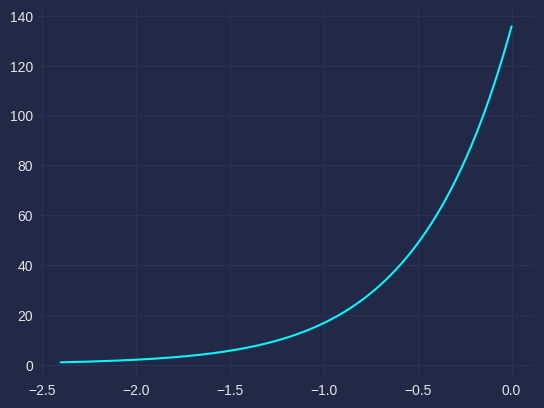

In [80]:
plt.plot(t.detach(),H_quin.detach())

In [81]:
t==N

False